In [2]:
import numpy as np
import matplotlib.pyplot as plt

If x is not shifted as done in the following code, numerical instability arises in the algorithm:

When evaluating C_Fourier_0_N at +2pi and -2pi, both the numerator and the denominator of that function become zero, and one divides two small numbers. This leads to the numerical instability. The 0th Fourier cardinal function is exactly evaluated at 2pi if one has an N-point Chebyshev-Lobatto grid and evaluates the Nth Chebyshev polynomial at zero.

Since the 0th Fourier cardinal function is supposed to be periodic with period 2pi, I now simply shift all arguments to lie between -pi and pi, where no instabilities occur. You can either add the code x = np.mod(x + np.pi, 2*np.pi) - np.pi as the first line in your definition of C_Fourier_0_N , or copy-paste from the attached jupyter notebook.



In [12]:
# Chebyshev Lobatto grid points
c_a_N = lambda alpha, N: 0.5*(np.cos(np.pi*alpha/N)+1)

# Here we construct the Chebyshev polynomials from trigonometric functions
# See 'Cardinal functions' in https://deepblue.lib.umich.edu/handle/2027.42/29694
def C_Fourier_0_N(x, N):
    result = np.zeros(x.shape)
    x = np.mod(x + np.pi, 2*np.pi) - np.pi # comment out this line to see anomalous behavior
    result[np.abs(x)> 1e-16] = np.sin(N*x[np.abs(x)>1e-16])/np.tan(x[np.abs(x)>1e-16]/2)/(2*N)
    result[np.abs(x)<=1e-16] = 1.
    return result
C_Fourier_j_N = lambda x, j, N: C_Fourier_0_N(x-j*np.pi/N, N) #this takes values from -pi to 2pi
C_Chebysh_j_N = lambda x, j, N: (C_Fourier_j_N(np.arccos(x), j, N) + C_Fourier_j_N(np.arccos(x), -j, N))/(1 + (j==0 or j==N)) #this takes values from 0 to pi
# The following P_a_N are the Chebyshev polynomials used in arxiv:2311.12554
P_a_N = lambda x, alpha, N: C_Chebysh_j_N(2*x-1, alpha, N) #this takes values from -1 to 1

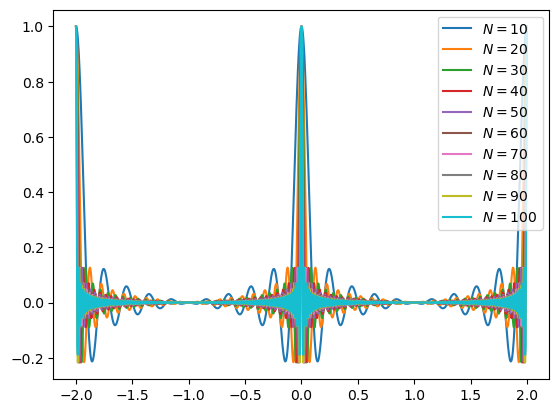

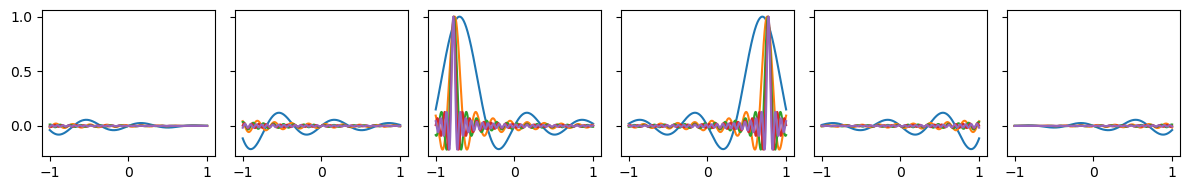

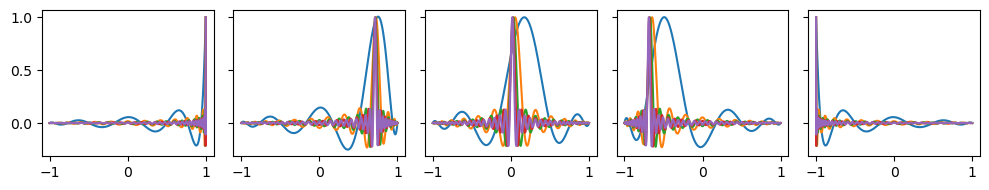

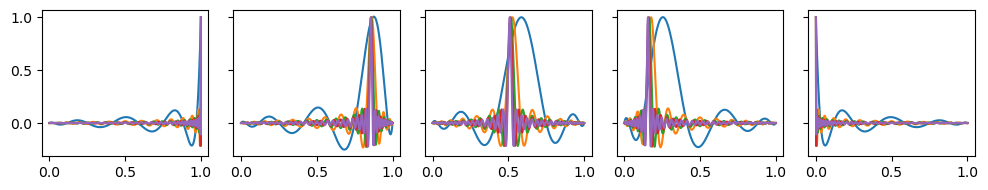

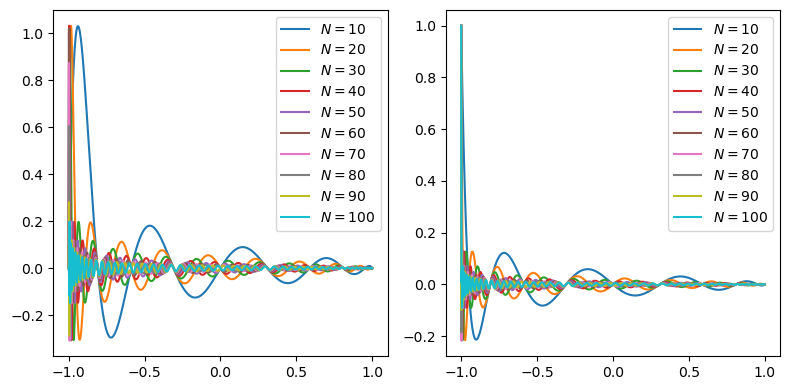

In [13]:
# 0th Fourier function
fig, ax = plt.subplots()
xs = np.linspace(-2*np.pi, 2*np.pi, 1001)
for chi in np.arange(11, 102, 10):
    N = chi-1
    ax.plot(xs/np.pi, C_Fourier_0_N(xs, N), label=rf'${N=:d}$')
ax.legend()
plt.show()

# jth Fourier function
j_ratios = [-0.75, -0.5, -0.25, 0.25, 0.5, 0.75]
xs = np.linspace(-1, 1, 1001)
fig, axs = plt.subplots(ncols=len(j_ratios), sharex=True, sharey=True, figsize=(len(j_ratios)*2, 2))
for j_ratio, ax in zip(j_ratios, axs):
    for chi in np.arange(10, 101, 20):
        N = chi-1
        j = int(j_ratio * N)
        ax.plot(xs, C_Fourier_j_N(xs, j, N), label=rf'${j=:d}, {N=:d}$')
    # ax.legend(handlelength=0.3,
    #           handletextpad=0.2,
    #           labelspacing=0.2)
plt.tight_layout()
plt.show()

# jth Chebyshev function
j_ratios = [0., 0.25, 0.5, 0.75, 1.]
xs = np.linspace(-1, 1, 1001)
fig, axs = plt.subplots(ncols=len(j_ratios), sharex=True, sharey=True, figsize=(len(j_ratios)*2, 2))
for j_ratio, ax in zip(j_ratios, axs):
    for chi in np.arange(10, 101, 20):
        N = chi-1
        j = int(j_ratio * N)
        ax.plot(xs, C_Chebysh_j_N(xs, j, N), label=rf'${j=:d}, {N=:d}$')
    # ax.legend(handlelength=0.3,
    #           handletextpad=0.2,
    #           labelspacing=0.2)
plt.tight_layout()
plt.show()

# scaled jth Chebyshev function
j_ratios = [0., 0.25, 0.5, 0.75, 1.]
xs = np.linspace(0., 1., 1001)
fig, axs = plt.subplots(ncols=len(j_ratios), sharex=True, sharey=True, figsize=(len(j_ratios)*2, 2))
for j_ratio, ax in zip(j_ratios, axs):
    for chi in np.arange(10, 101, 20):
        N = chi-1
        j = int(j_ratio * N)
        ax.plot(xs, P_a_N(xs, j, N), label=rf'${j=:d}, {N=:d}$')
    # ax.legend(handlelength=0.3,
    #           handletextpad=0.2,
    #           labelspacing=0.2)
plt.tight_layout()
plt.show()

# Nth Chebyshev function
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
xs = np.linspace(-1, 1, 1001)

ax = axs[0]
for chi in np.arange(11, 102, 10):
    N = chi-1
    ax.plot(xs, C_Chebysh_j_N(xs, N-1, N), label=rf'${N=:d}$')
ax.legend()

ax = axs[1]
for chi in np.arange(11, 102, 10):
    N = chi-1
    ax.plot(xs, C_Chebysh_j_N(xs, N, N), label=rf'${N=:d}$')
ax.legend()

plt.tight_layout()
plt.show()

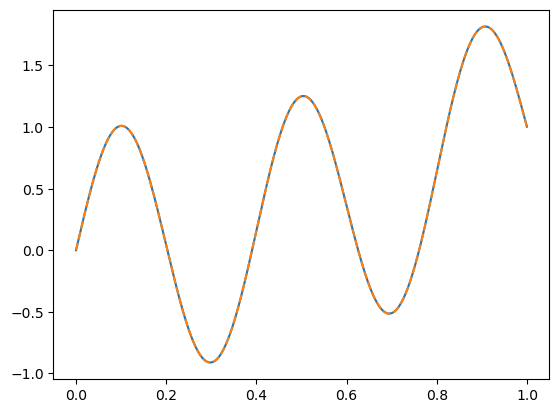

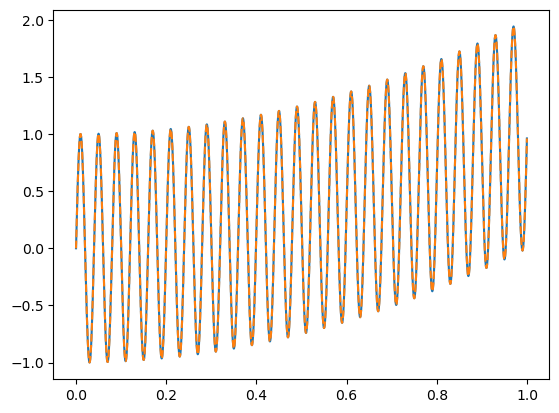

In [14]:
# define function that constructs MPS tensors of Chebyshev interpolation
def Chebyshev_interpolation(func, L, chi):
    N = chi-1
    args = 0.5 * (np.arange(2)[:, None] + c_a_N(np.arange(N+1), N)[None, :]) # see Eqs. (4.1) and (4.2)
    As = []
    # construct (data-dependent) left tensor
    A = func(args)[None] # (1, 2, chi)
    As.append(A)
    # construct (data-independent) bulk tensors from Chebyshev polynomials
    for i in range(1, L-1):
        A = np.array([P_a_N(args, alpha, N) for alpha in range(N+1)]) # (chi, 2, chi)
        As.append(A)
    # construct (data-independent) final tensor from Chebyshev polynomials
    A = np.array([P_a_N(np.arange(2)/2, alpha, N) for alpha in range(N+1)])[:, :, None] # (chi, 2, 1)
    As.append(A)
    return As

# Example 1: create a function to interpolate
test_func = lambda x: np.sin(5*np.pi*x) + x**2

# MPS from Chebyshev interpolation
L = 12
chi = 500
As = Chebyshev_interpolation(test_func, # function to be interpolated
                             L=L,       # number of MPS tensors
                             chi=chi)   # bond dimension

# Plot function and interpolation below

# contract full MPS (should only do this for small L <= 20)
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# exact function values
xs = np.linspace(0, 1, 2**L, endpoint=False)
func_vals = test_func(xs)

# plot result
plt.plot(xs, func_vals, '-')
plt.plot(xs, func_interp, '--')
plt.show()

# Example 2: create a highly oscillatory function to interpolate
test_func = lambda x: np.sin(50*np.pi*x) + x**2

# MPS from Chebyshev interpolation
L = 12
chi = 500
As = Chebyshev_interpolation(test_func, # function to be interpolated
                             L=L,       # number of MPS tensors
                             chi=chi)   # bond dimension

# Plot function and interpolation below

# contract full MPS (should only do this for small L <= 20)
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# exact function values
xs = np.linspace(0, 1, 2**L, endpoint=False)
func_vals = test_func(xs)

# plot result
plt.plot(xs, func_vals, '-')
plt.plot(xs, func_interp, '--')
plt.show()

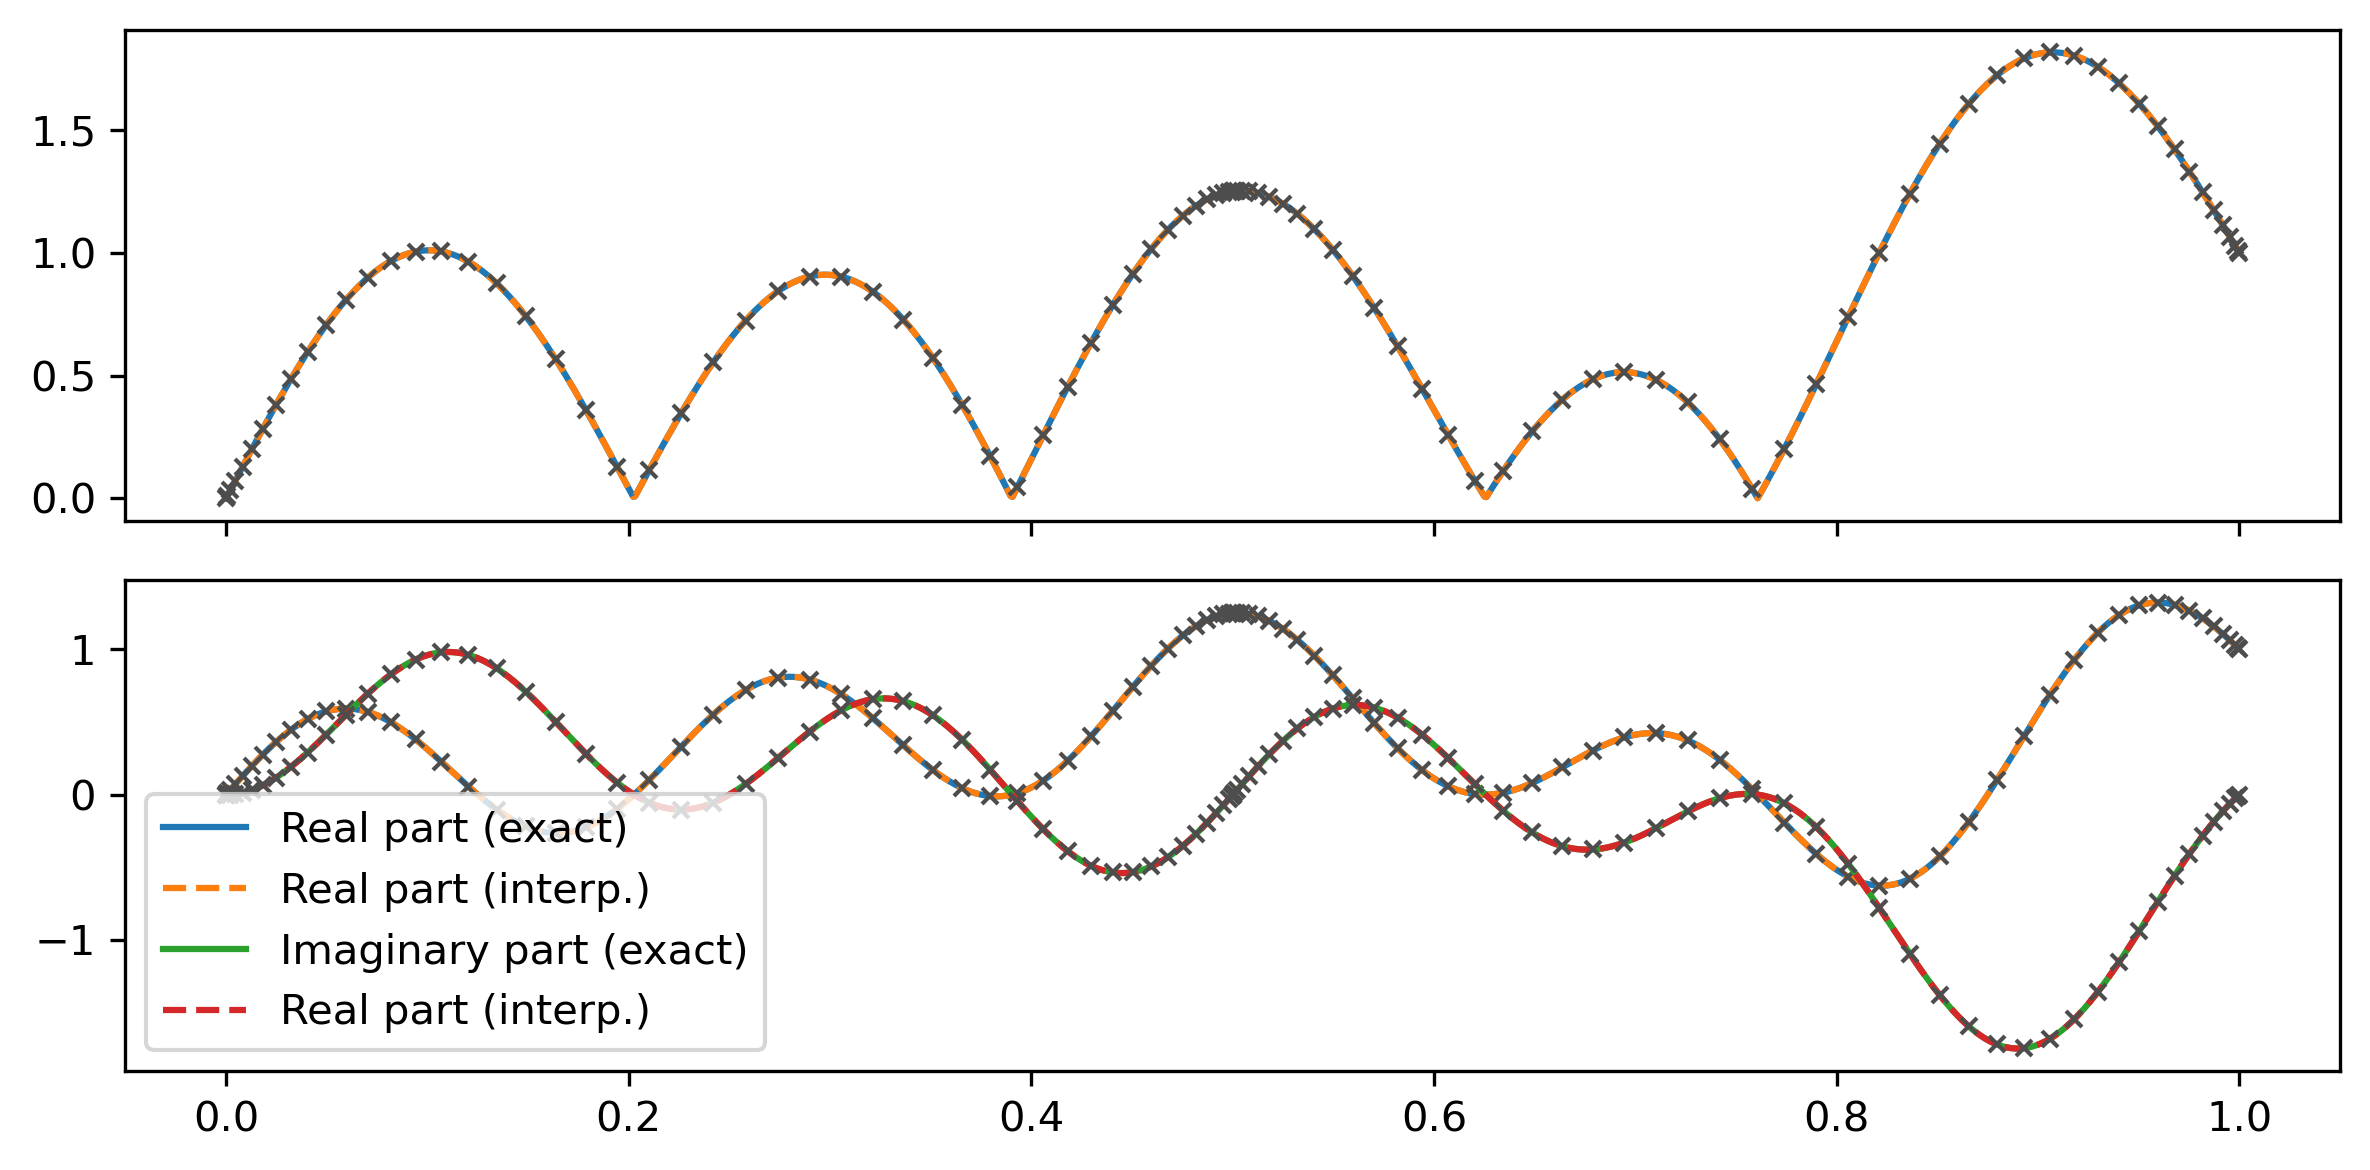

In [15]:
# Example: create complex-valued test function
complex_test_func = lambda x: (np.sin(5*np.pi*x) + x**2) * np.exp(1j*4*np.pi*x)

# get MPS from Chebyshev interpolation
chi = 50
As = Chebyshev_interpolation(complex_test_func, # function to be interpolated
                             L=10,              # number of MPS tensors
                             chi=chi)           # (half of the) bond dimension
# also plot points on which the function was evaluated
Cheb_xs = 0.5 * np.sort(np.arange(2)[:, None] + c_a_N(np.arange(chi), chi-1)[None, :])
Cheb_vals = complex_test_func(Cheb_xs)

# contract MPS to reconstruct interpolated function
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = complex_test_func(xs)

# plot results
fig, axs = plt.subplots(nrows=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(xs, np.abs(func_vals))
axs[0].plot(xs, np.abs(func_interp), '--')
axs[0].plot(Cheb_xs, np.abs(Cheb_vals), 'x', ms=4, color='0.3')

axs[1].plot(xs, func_vals.real, label='Real part (exact)')
axs[1].plot(xs, func_interp.real, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.real, 'x', ms=4, color='0.3')
axs[1].plot(xs, func_vals.imag, label='Imaginary part (exact)')
axs[1].plot(xs, func_interp.imag, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.imag, 'x', ms=4, color='0.3')
axs[1].legend()

plt.tight_layout()
plt.show()